# Bayesian optimization with fixed features
In some contexts a variable/feature needs to be fixed during optimization. However, we
can leverage previous measurements near the fixed variable value to potentially
jump-start optimization using observed model covariances established by the GP kernel
. In this example, we start with a number of random observations in 2D input space
and then proceed with BO at a fixed value for one of the variables. This notebook
uses the 2D Rosenbrock test function as an example.

In [1]:
# set values if testing
import os

from xopt.generators.bayesian.visualize import plot_model_prediction
from xopt import Xopt, Evaluator
from xopt.generators.bayesian import UpperConfidenceBoundGenerator
from xopt.resources.test_functions.rosenbrock import (
    evaluate_rosenbrock,
    make_rosenbrock_vocs,
)

# Ignore all warnings
import warnings

warnings.filterwarnings("ignore")


SMOKE_TEST = os.environ.get("SMOKE_TEST")
NUM_MC_SAMPLES = 1 if SMOKE_TEST else 128
NUM_RESTARTS = 1 if SMOKE_TEST else 20

# make rosenbrock function vocs in 2D
vocs = make_rosenbrock_vocs(2)

# define a fixed value for the BO generator
fixed_features = {"x0": -1.0}
generator = UpperConfidenceBoundGenerator(vocs=vocs, fixed_features=fixed_features)
generator.numerical_optimizer.n_restarts = NUM_RESTARTS
generator.n_monte_carlo_samples = NUM_MC_SAMPLES

evaluator = Evaluator(function=evaluate_rosenbrock)

X = Xopt(generator=generator, evaluator=evaluator, vocs=vocs)
X


            Xopt
________________________________
Version: 2.4.6.dev5+ga295b108.d20250107
Data size: 0
Config as YAML:
dump_file: null
evaluator:
  function: xopt.resources.test_functions.rosenbrock.evaluate_rosenbrock
  function_kwargs:
    dummy: 1
    label: y
  max_workers: 1
  vectorized: false
generator:
  beta: 2.0
  computation_time: null
  custom_objective: null
  fixed_features:
    x0: -1.0
  gp_constructor:
    covar_modules: {}
    custom_noise_prior: null
    mean_modules: {}
    name: standard
    trainable_mean_keys: []
    transform_inputs: true
    use_cached_hyperparameters: false
    use_low_noise_prior: true
  log_transform_acquisition_function: false
  max_travel_distances: null
  memory_length: null
  model: null
  n_candidates: 1
  n_interpolate_points: null
  n_monte_carlo_samples: 128
  name: upper_confidence_bound
  numerical_optimizer:
    max_iter: 2000
    max_time: null
    n_restarts: 20
    name: LBFGS
  supports_batch_generation: true
  turbo_controll

## Generate some initial random samples in 2D space

In [2]:
X.random_evaluate(10)

x0        x1            y  xopt_runtime  xopt_error
0 -0.717639 -0.760903   165.744493      0.000008       False
1  1.809949  0.136754   986.088717      0.000004       False
2  1.466283  1.278063    76.242335      0.000003       False
3 -1.207657 -1.840422  1093.119914      0.000002       False
4  1.638804  0.816045   349.960573      0.000002       False
5  1.415589 -0.221908   495.591956      0.000002       False
6  1.244505  0.732504    66.692390      0.000002       False
7 -1.585345  1.133510   197.071250      0.000002       False
8 -1.786659  0.903711   531.461389      0.000002       False
9 -1.050862 -0.948528   425.620946      0.000002       False

## Run BO steps with fixed features

In [3]:
for i in range(5):
    X.step()

In [4]:
X.data

x0        x1            y  xopt_runtime  xopt_error
0  -0.717639 -0.760903   165.744493      0.000008       False
1   1.809949  0.136754   986.088717      0.000004       False
2   1.466283  1.278063    76.242335      0.000003       False
3  -1.207657 -1.840422  1093.119914      0.000002       False
4   1.638804  0.816045   349.960573      0.000002       False
5   1.415589 -0.221908   495.591956      0.000002       False
6   1.244505  0.732504    66.692390      0.000002       False
7  -1.585345  1.133510   197.071250      0.000002       False
8  -1.786659  0.903711   531.461389      0.000002       False
9  -1.050862 -0.948528   425.620946      0.000002       False
10 -1.000000  0.129825    79.720514      0.000008       False
11 -1.000000  1.312389    13.758672      0.000007       False
12 -1.000000  2.000000   104.000000      0.000010       False
13 -1.000000  0.888432     5.244747      0.000008       False
14 -1.000000  0.996192     4.001450      0.000007       False

## Visualize model and evaluations
Note that for the BO samples, they all are on the line $x_0=-1$

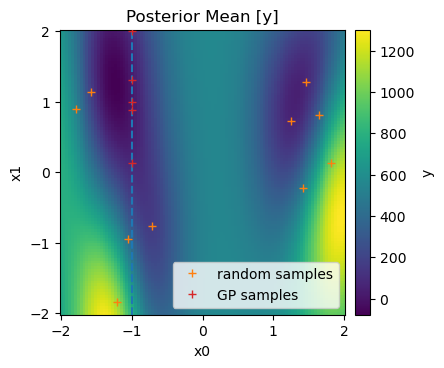

In [5]:
ax = plot_model_prediction(
    model=X.generator.model,
    vocs=X.vocs,
    data=X.data,
    show_samples=False,
    n_grid=100,
)
ax.plot(
    *X.data[["x0", "x1"]].to_numpy()[:10].T, "+C1", label="random samples", zorder=10
)
ax.plot(*X.data[["x0", "x1"]].to_numpy()[10:].T, "+C3", label="GP samples", zorder=10)
ax.axvline(-1.0, ls="--")
ax.legend();

## Run with fixed feature that is not in vocs
We can also run fixed features where the fixed variable is not listed in vocs, as
long as the generator data contains data corresponding to the fixed feature name. To
satisfy this requirements we add the data from the last optimization run.

In [6]:
# make rosenbrock function vocs in 2-D but remove the `x0` name (set to a fixed
# feature in the next cell)
vocs = make_rosenbrock_vocs(2)
vocs.variables = {"x1": [-2.0, 2.0]}

In [7]:
# define a fixed value for the BO generator
fixed_features = {"x0": -1.0}
generator = UpperConfidenceBoundGenerator(vocs=vocs, fixed_features=fixed_features)
generator.numerical_optimizer.n_restarts = NUM_RESTARTS
generator.n_monte_carlo_samples = NUM_MC_SAMPLES

evaluator = Evaluator(function=evaluate_rosenbrock)

X2 = Xopt(generator=generator, evaluator=evaluator, vocs=vocs)
X2.add_data(X.data)

In [8]:
# run an optimization step
X2.step()

In [9]:
X2.data

x0        x1            y  xopt_runtime  xopt_error
0  -0.717639 -0.760903   165.744493      0.000008       False
1   1.809949  0.136754   986.088717      0.000004       False
2   1.466283  1.278063    76.242335      0.000003       False
3  -1.207657 -1.840422  1093.119914      0.000002       False
4   1.638804  0.816045   349.960573      0.000002       False
5   1.415589 -0.221908   495.591956      0.000002       False
6   1.244505  0.732504    66.692390      0.000002       False
7  -1.585345  1.133510   197.071250      0.000002       False
8  -1.786659  0.903711   531.461389      0.000002       False
9  -1.050862 -0.948528   425.620946      0.000002       False
10 -1.000000  0.129825    79.720514      0.000008       False
11 -1.000000  1.312389    13.758672      0.000007       False
12 -1.000000  2.000000   104.000000      0.000010       False
13 -1.000000  0.888432     5.244747      0.000008       False
14 -1.000000  0.996192     4.001450      0.000007       False
15 -1.000000  1.002598     4.000675      0.000007       False